In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy

In [3]:
import os
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import img_to_array
from keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.optimizers import rmsprop_v2
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.layers import LayerNormalization
from skimage import color
from skimage.transform import resize, rotate

In [4]:
SIZE = 256
# /content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_photos
image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_training_cropped_photos/'
img_array = []

sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_training_cropped_sketches/'
sketch_array = []

test_image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_photos/'
test_img_array = []

test_sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_sketches/'
test_sketch_array = []

# Image and their corresponding file names in a sorted manner based on their names
image_file = sorted(os.listdir(image_path))
sketch_file = sorted(os.listdir(sketch_path))
test_image_file = sorted(os.listdir(test_image_path))
test_sketch_file = sorted(os.listdir(test_sketch_path))


In [5]:
def image_preprocessing(file_name, img_path, size):
  storage_array = []
  for img_file in tqdm(file_name):
    x = img_path + img_file
    img = (cv2.resize(cv2.imread(x).astype('float32'),(SIZE,SIZE)))/255.0
    storage_array.append(img)
    
  # Returning storage array where we have stored all our pre-processed images
  return np.array(storage_array)
  

In [6]:
img_array = image_preprocessing(image_file, image_path, SIZE)
sketch_array = image_preprocessing(sketch_file, sketch_path, SIZE)
test_img_array = image_preprocessing(test_image_file, test_image_path, SIZE)
test_sketch_array = image_preprocessing(test_sketch_file, test_sketch_path, SIZE)

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


In [7]:
'''
test_img_array = img_array[-300:]
test_sketch_array = sketch_array[-300:]
img_array = img_array[:-300]
sketch_array = sketch_array[:-300]
'''

'\ntest_img_array = img_array[-300:]\ntest_sketch_array = sketch_array[-300:]\nimg_array = img_array[:-300]\nsketch_array = sketch_array[:-300]\n'

In [8]:
# Print the number of colored and sketch images present
print("Total number of Training Colored images:",len(img_array))
print("Total number of Training sketch images:",len(sketch_array))
print("Total number of Testing Colored images:",len(test_img_array))
print("Total number of Testing sketch images:",len(test_sketch_array))

Total number of Training Colored images: 88
Total number of Training sketch images: 88
Total number of Testing Colored images: 100
Total number of Testing sketch images: 100


In [9]:
# Converting the image arrays into numpy for easy processing 
img_array_n = np.array(img_array)
sketch_array_n = np.array(sketch_array)

test_img_array_n = np.array(test_img_array)
test_sketch_array_n = np.array(test_sketch_array)

# Printing the shapes of the image 
print("The shape of the train colored image array is:", img_array_n.shape)
print("The shape of the train sketched image array is:", sketch_array_n.shape)

print("The shape of the test colored image array is:", test_img_array_n.shape)
print("The shape of the test sketched image array is:", test_sketch_array_n.shape)

The shape of the train colored image array is: (88, 256, 256, 3)
The shape of the train sketched image array is: (88, 256, 256, 3)
The shape of the test colored image array is: (100, 256, 256, 3)
The shape of the test sketched image array is: (100, 256, 256, 3)


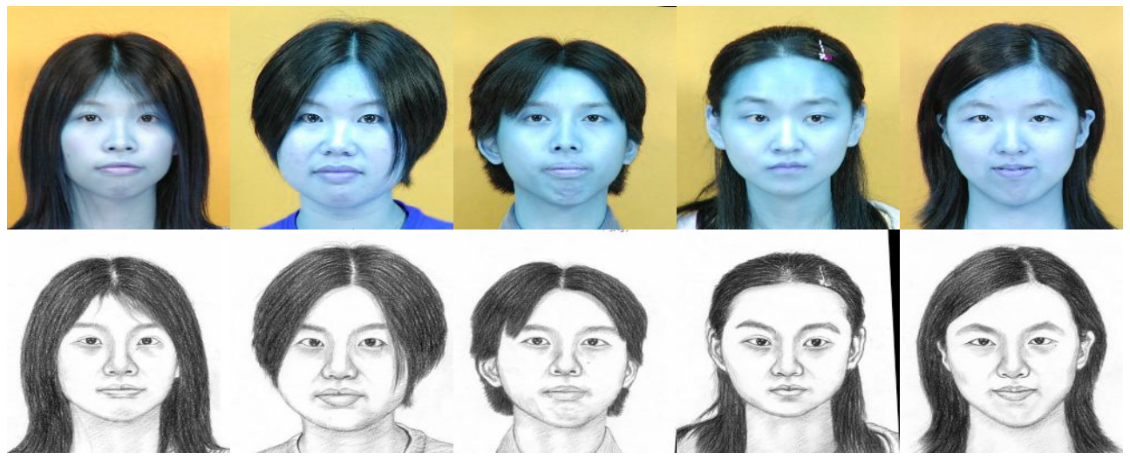

In [10]:
# Plotting the training images to see
some_photos = np.concatenate([i for i in img_array_n[:5]],axis=1)
some_sketches = np.concatenate([i for i in sketch_array_n[:5]],axis=1)
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([some_photos,some_sketches]))
plt.axis("OFF")
plt.show()

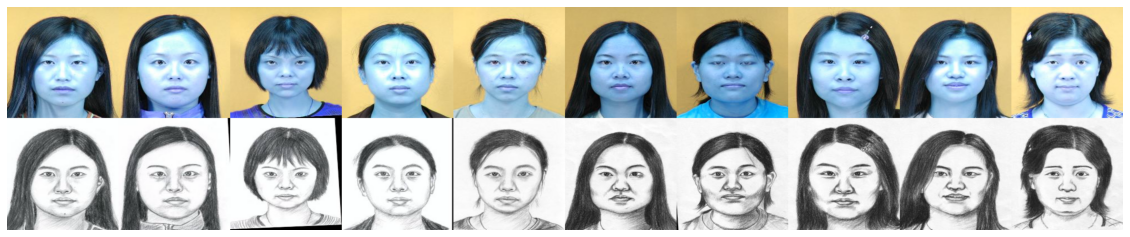

In [11]:
# Plotting the testing images to see
some_photos = np.concatenate([i for i in test_img_array_n[:10]],axis=1)
some_sketches = np.concatenate([i for i in test_sketch_array_n[:10]],axis=1)
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([some_photos,some_sketches]))
plt.axis("OFF")
plt.show()

In [12]:
(X_train, y_train), (X_test, y_test) = (img_array_n, sketch_array_n), (test_img_array_n, test_sketch_array_n)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((88, 256, 256, 3), (88, 256, 256, 3), (100, 256, 256, 3), (100, 256, 256, 3))

## Construction of Encoder

In [14]:
img_height   = X_train.shape[1]    # 256
img_width    = X_train.shape[2]    # 256
num_channels = X_train.shape[3]    # 3

input_shape =  (img_height, img_width, num_channels)   # (256, 256, 3) 
latent_dim = 4   # Dimension of the latent space

In [15]:
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder_conv = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_conv)
encoder_conv = keras.layers.BatchNormalization()(encoder_conv)
encoder_conv = keras.layers.LeakyReLU()(encoder_conv)

encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

Instructions for updating:
Colocations handled automatically by placer.


## To determine the values in the latent space layer

In [16]:
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

## Reparameterization 

In [17]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

In [18]:
conv_shape = K.int_shape(encoder_conv)

In [19]:
conv_shape

(None, 2, 2, 512)

## Construction of Decoder

In [20]:
decoder_input = Input(shape=(latent_dim,))

decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

decoder_conv = Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv = keras.layers.Dropout(0.1)(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.Dropout(0.1)(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = keras.layers.LeakyReLU()(decoder_conv)

decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)

decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, padding='same', activation='sigmoid')(decoder_conv)

## Connecting the encoder and decoder

In [21]:
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)

## The output of vae model is the output of decoder in which its input is taken from the output of encoder

In [22]:
vae = Model(encoder_input, decoder(encoder(encoder_input)))

## Summary of autoencoder

In [23]:
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 4)                 1593816   
                                                                 
 model_1 (Functional)        (None, 256, 256, 3)       3943251   
                                                                 
Total params: 5,537,067
Trainable params: 5,535,211
Non-trainable params: 1,856
_________________________________________________________________


## Summary of encoder

In [24]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 16)   1168        ['conv2d[0][0]']                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['conv2d_1[0][0]']           

## Summary of decoder

In [25]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              10240     
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        2359808   
 nspose)                                                         
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                           

## Defining loss function

In [26]:
def kl_reconstruction_loss(true, pred):    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height    
    
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5    
    
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

## Compiling the model

In [27]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

## Training the model

In [28]:
history = vae.fit(x=X_train, y=y_train, epochs=500, batch_size=16, validation_data=(X_test,y_test))

Train on 88 samples, validate on 100 samples
Epoch 1/500
88/88 [==============================] - ETA: 0s - loss: 44321.3260

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


88/88 [==============================] - 16s 183ms/sample - loss: 44321.3260 - val_loss: 44196.0814
Epoch 2/500
88/88 [==============================] - 0s 6ms/sample - loss: 36333.5662 - val_loss: 42017.0003
Epoch 3/500
88/88 [==============================] - 0s 5ms/sample - loss: 30929.1740 - val_loss: 41019.2050
Epoch 4/500
88/88 [==============================] - 0s 5ms/sample - loss: 27885.2482 - val_loss: 40366.9437
Epoch 5/500
88/88 [==============================] - 0s 6ms/sample - loss: 25969.6428 - val_loss: 39182.2203
Epoch 6/500
88/88 [==============================] - 0s 6ms/sample - loss: 24975.9705 - val_loss: 38736.3000
Epoch 7/500
88/88 [==============================] - 0s 5ms/sample - loss: 24436.7821 - val_loss: 39195.8247
Epoch 8/500
88/88 [==============================] - 0s 6ms/sample - loss: 24090.7738 - val_loss: 39085.1444
Epoch 9/500
88/88 [==============================] - 0s 5ms/sample - loss: 23513.7745 - val_loss: 39258.1297
Epoch 10/500
88/88 [========

## Loss value of both train and test data

Text(0, 0.5, 'Loss')

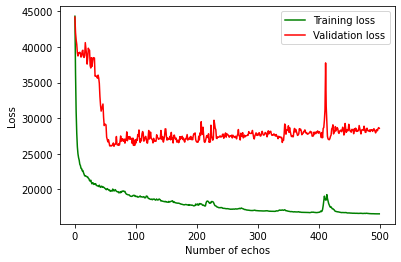

In [29]:
plt.plot(history.history['loss'], color='green')
plt.plot(history.history['val_loss'], color='red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Number of echos')
plt.ylabel('Loss')

## Displaying latent space

In [30]:
encoded = encoder.predict(X_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Decoding data points in latent space

In [31]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))

    print(new_points.shape)

    new_images = decoder.predict(new_points)
    print(new_images.shape)
    
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2], new_images.shape[3])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False, sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


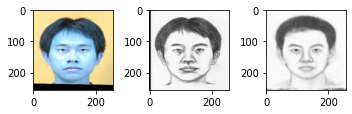

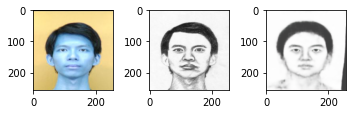

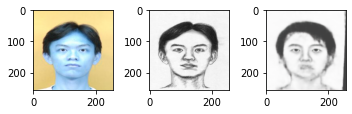

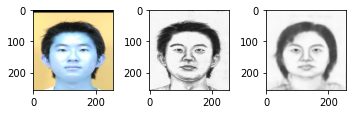

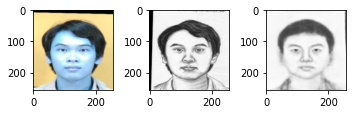

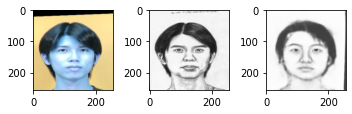

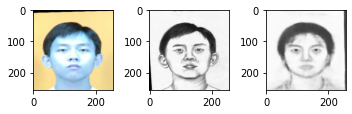

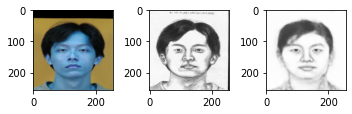

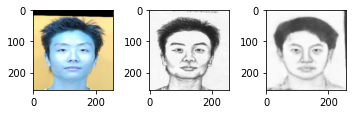

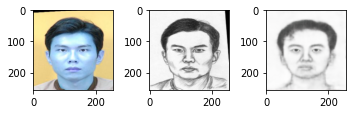

In [32]:
for i in range(60,70):
  img_no = i
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
  axes[0].imshow(X_test[img_no])
  axes[1].imshow(y_test[img_no])
  axes[2].imshow(vae.predict(X_test)[img_no])
  fig.tight_layout()